# Individual Machine Learning II Project 1
### Andrew Martinez

## Executive Summary

This report deals with the analysis of turnover at an unidentified firm using an HR data set with the hopes of developing a model to predict future turnover. The model selected for this purpose will be logistic regression with a number of statistical and machine learning techniques implemented in order to optimize its performance. The final developed model was able to predict turnover at approximately a 94% accuracy accross different training/testing paritions of historical data.

## Step 1: Data Loading and Library Imports

This first section deals with the import of necessary libraries and functions for this analysis. Custom built functions can be found in the ML_Helper_Function.py file. A simple describe analysis demonstrates that there 10 variables (9 exogenous and 1 endogenous) in the raw data set with a combination of numerical, boolean, and categorical variables present

In [157]:
import numpy as np
import pandas as pd
import featuretools as ft
import matplotlib.pyplot as plt 
import ML_Helper_Functions as hf #File with custom-built functions
from sklearn import preprocessing
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report, roc_curve
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Load csv from path and provide summary statistics
file_path = '/Users/andrewmartinez/Documents/MBD/Machine Learning II/Individual Project Data/turnover.csv'

raw_df = hf.read_data(file_path)
raw_df.describe(include = 'all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


# Step 2: Data Exploration and Preparation

In this section, further analysis into the data itself as well as preparation for the modeling stages were undertaken. 

In [158]:
raw_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Preliminary analysis reveals that there are no missing values among any of the variables.

In [159]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


The following charts reveal that concentrated pockets of turnover exist when an employee exhibits: 1) a sub 50% satisfaction and low average monthly hours (150 and below), 2) high satisfaction level and high average monthly hours as well as 3) very low satisfication level and high average monthly hours. While the third category intuitively makes sense, the first could be explained by employees that are either bored or are part-time contractors and the second high performers who are able to find a better role. 

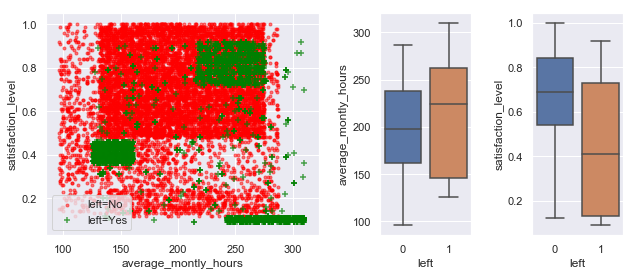

In [160]:
hf.plot_descriptive_satisfaction(raw_df)

The following charts reveal that concentrated pockets of turnover exist when an employee exhibits: 1) a lower last evaluation metric and low average monthly hours and 2) high last evaluation metric and high average monthly hours. The latter group likely falls under the aforementioned "high performers" who find a better role, while the first group are clearly low performers who might have been forced out or moved elsewhere on their own volition.

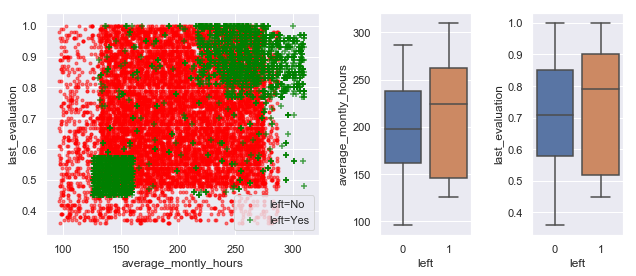

In [161]:
hf.plot_descriptive_last_evaluation(raw_df)

The following chart demonstrates that the majority of employee turnover occurred for medium length tenures (i.e. 2-5 years) with significant peaks at each annual interval (possibly around the time of compensation/performance discussions). While the majority of employees that have remained are also in this tenure bracket, in general employees of both shorter and longer duration tenures tend to remain.  

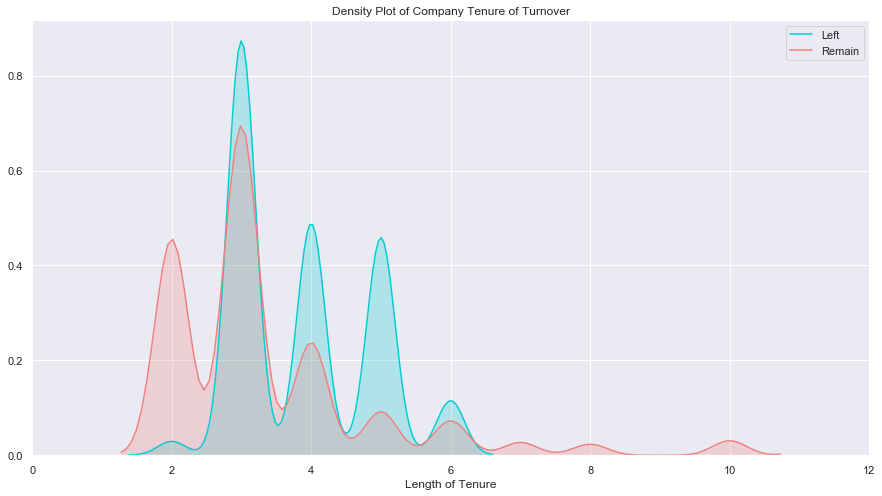

In [162]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(raw_df["time_spend_company"][raw_df.left == 1], color="darkturquoise", shade=True)
sns.kdeplot(raw_df["time_spend_company"][raw_df.left == 0], color="lightcoral", shade=True)
plt.legend(['Left', 'Remain'])
plt.title('Density Plot of Company Tenure of Turnover')
ax.set(xlabel='Length of Tenure')
plt.xlim(0,12)
plt.show()

Similar to previous plots, it can be seen in this graph that employees that have left the firm tend to fall on the two extremes of high and low average monthly hours.

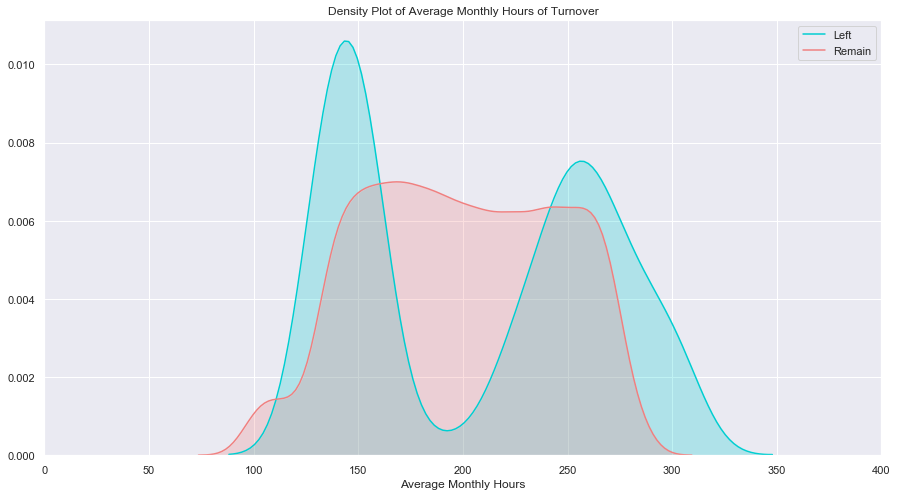

In [163]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(raw_df["average_montly_hours"][raw_df.left == 1], color="darkturquoise", shade=True)
sns.kdeplot(raw_df["average_montly_hours"][raw_df.left == 0], color="lightcoral", shade=True)
plt.legend(['Left', 'Remain'])
plt.title('Density Plot of Average Monthly Hours of Turnover')
ax.set(xlabel='Average Monthly Hours')
plt.xlim(0,400)
plt.show()

In [164]:
#Group variables by variable type
nums = hf.numerical_features(raw_df)
cat = hf.categorical_features(raw_df)
bools = hf.boolean_features(raw_df)

It can be seen from the following chart that the majority of employees fall under the low and medium salary bands.

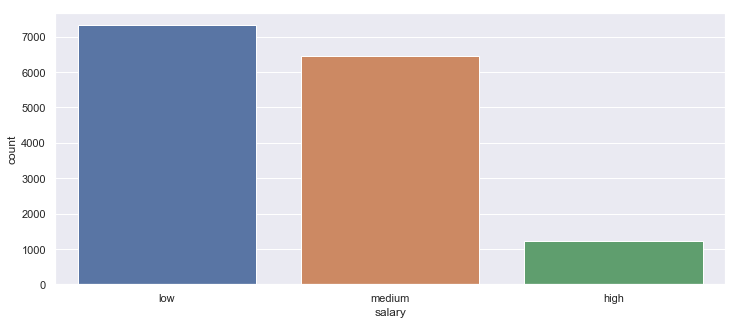

In [165]:
hf.categorical_plot(raw_df, cat, 0)    

It can be seen from the below chart that majority of employees fall under the sales, technical, support, and IT departments.

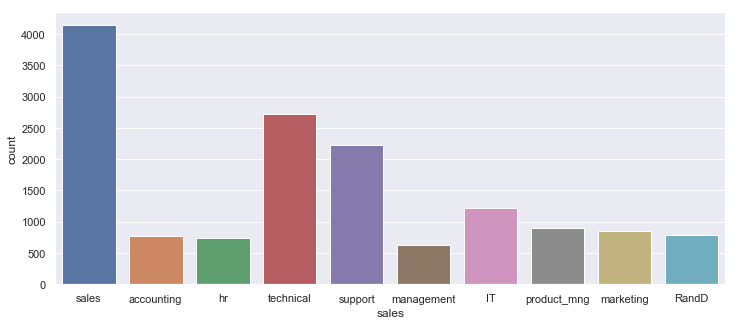

In [166]:
hf.categorical_plot(raw_df,cat, 1)

The categorical variable "salary" will be converted to both a scale variable and dummy variable in order to determine which provides superior performance for the model. Latter stages will test both and keep variables that are more significant to the model.

In [167]:
#Scale the salary variable
categorical_df = hf.categorical_to_scale(raw_df, 'salary')
categorical_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,sal_band
0,0.38,0.53,2,157,3,0,1,0,sales,low,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,0


In [168]:
#Create dummy variables for categorical variables
encoded_df = hf.onehot_encode(categorical_df)
encoded_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sal_band,salary_high,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


From the below, we can determine that although the majority class are the employees that have not left, the data is still fairly balanced.

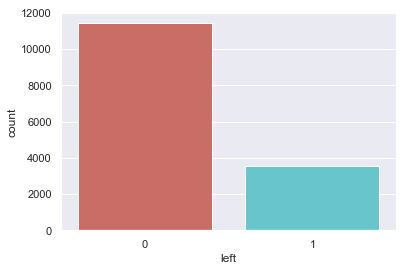

In [169]:
sns.countplot(x='left', data = categorical_df, palette = 'hls')

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


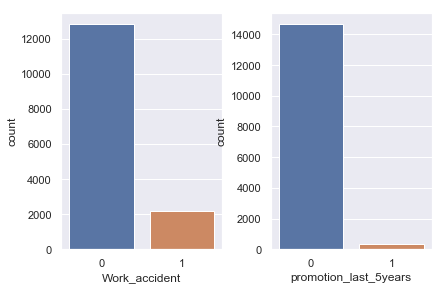

In [170]:
#Keep track of boolean variables after encoding
booleans = hf.boolean_features(encoded_df)

fig, ax = plt.subplots(1,2)
fig.tight_layout()
sns.countplot(encoded_df[booleans[0]], ax=ax[0])
sns.countplot(encoded_df[booleans[2]], ax=ax[1])

fig.show()

Although the previous charts showed that with regards to the promotion variable, the data might not be balanced, the following check allays those concerns as all boolean categories in the data set have a sample size of at least 40.

In [171]:
#Checks if any boolean variables are imbalanced within sample set
distribution = hf.boolean_dist(encoded_df, booleans)

counter = 0
for col in distribution:
    if col[0] < 40 | col[1] < 40:
        print(col)
    else:
        counter+=1
    
    if counter == len(distribution):
        print("Booleans are balanced")
        

Booleans are balanced


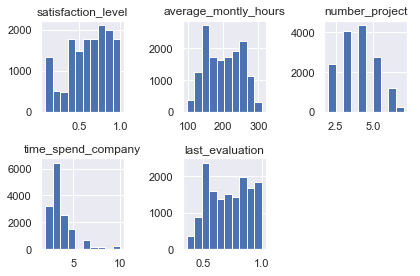

In [172]:
non_bool_numerics = list(set(nums) - set(bools))
hf.draw_histograms(encoded_df, non_bool_numerics, 2, 3)

As it can be seen that some skewness is present in the tenure variable, it will be corrected in this section along with any other variables determined to be skewed. As the data exploration has largely been completed, the data will also be standardized for modeling.

In [173]:
prepared = encoded_df.copy()
prepared[non_bool_numerics] = hf.fix_skewness(encoded_df[non_bool_numerics])
prepared = hf.standardize(prepared, non_bool_numerics)
prepared.head()

/Users/andrewmartinez/Documents/MBD/Machine Learning II/ML_Helper_Functions.py:169: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  standardized_numericals = preprocessing.scale(df[numerical_values])


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sal_band,salary_high,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,-0.936495,-1.087275,-1.462863,-0.882040,-0.184396,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.752814,0.840707,0.971113,1.220423,1.632127,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,-2.022479,0.957554,2.593763,1.420657,0.626260,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0.431041,0.899131,0.971113,0.439508,1.200633,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-0.976716,-1.145699,-1.462863,-0.841993,-0.184396,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


After conducting correlation analysis, it can be seen that a few variables such as satisfaction and tenure have some correlation with the turnover variable. Furthermore, multicollinearity does not appear to a substanial issue which the exception of the created salary variables, which would intuitively make sense.

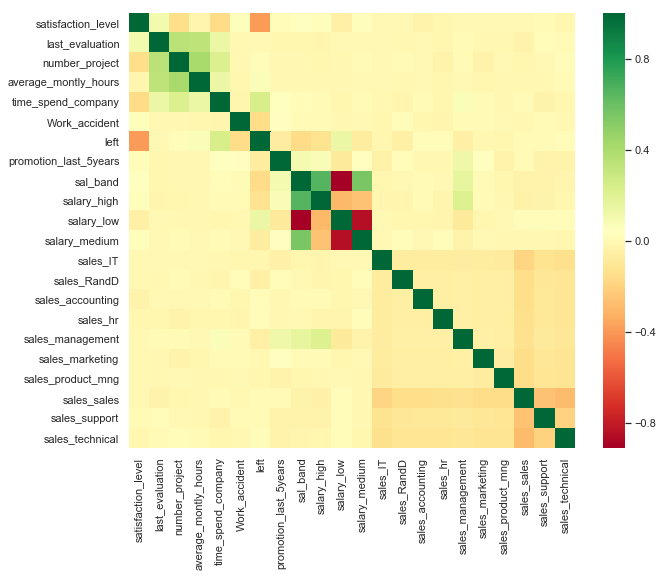

In [174]:
plt.figure(figsize=(10,8)) 
sns.heatmap(prepared.corr(), cmap="RdYlGn")
plt.show()

# Step 3: Train Baseline Model

This section of the analysis deals with the creation and testing of the baseline model. This model will use the cleaned data as it currently stands and exhibit no feature creation nor hyperparameter tuning. It will serve as the benchmark against all subsequent model changes.

In [175]:
# Split into train and test sets
size = 0.20
seed = 62592
target = 'left'
target_metric = 'accuracy'

features = list(prepared)
features.remove(target)

dependent_var = [target]
X = prepared.loc[:, features]
y = prepared.loc[:, dependent_var]

X = hf.correlation_removal(X)

Need to remove 0 columns with >= 0.99 correlation.


In [176]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


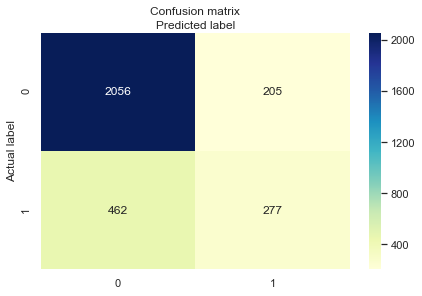

In [177]:
#Baseline Model
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
    
hf.confusion_heat_map(y_test, y_pred)

In [178]:
print('BASE LINE:')
print('Accuracy of logistic regression classifier on hold-out set: {:.2f}'.format(logreg.score(X_test, y_test)))
accuracy = hf.cv_evaluate(prepared, target, splits=100)
print('Mean Accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Best Accuracy after CV: {:.3f}'.format(max(accuracy)))
print()
print(classification_report(y_test, y_pred))

BASE LINE:
Accuracy of logistic regression classifier on hold-out set: 0.78
Mean Accuracy after CV: 0.790 +/- 0.010
Best Accuracy after CV: 0.805

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2261
           1       0.57      0.37      0.45       739

   micro avg       0.78      0.78      0.78      3000
   macro avg       0.70      0.64      0.66      3000
weighted avg       0.76      0.78      0.76      3000



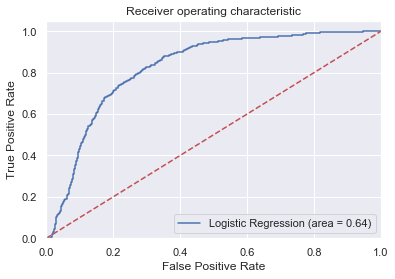

In [179]:
hf.ROC_curve(logreg, y_test, X_test)

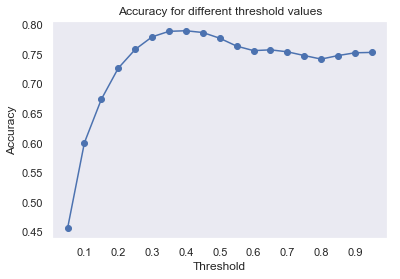

In [180]:
accuracy_list, threshold_list = hf.get_accuracy_list(logreg, X_test, y_test, y_pred)
hf.accuracy_plot(accuracy_list, threshold_list)

# Step 4 - Pipeline 1: Custom Feature Engineering and Deep Feature Synthesis

This section covers the first pipeline that will utilize a combination of manual feature engineering and Deep Feature Synthesis (DFS) for the purpose of creating new variables.

# Manual Feature Engineering

The manual feature engineering portion covers several functions including the removal of under represented features, calculating the average number of projects per year an employee undertakes, binning of continuous variables, and removal of outliers. 

According to the results, removal of under represented features and outliers had little effect (as there were no such features), while projects per year and binning had material effects on accuracy. Intuitively, projects per year could have an effect as an overworked employee undertaking many projects simultaneously would be more motivated to leave. Likewise, binning continuous variables would help improve the model as a marginal discrete change in variables such as monthly hours or number of projects would be less helpful in determining turnover than determining whether an employee falls into a higher or lower bucket in these categories.

In [181]:
# Remove outliers has been excluded to improve pipeline performance. Previous runs determined
# that no outliers were present.
fe_functions = ['under_represented_features', 'projects_per_year', 'bin_continuous_var']
#, 'remove_outliers']

tested_data = X.join(y)
funcs, new_dataset = hf.feature_engineering_pipeline(tested_data, target, size, seed, fe_functions)
accuracy = hf.cv_evaluate(new_dataset, 'left', splits=100)
print('Mean Accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Best Accuracy after CV: {:.3f}'.format(max(accuracy)))


Base Accuracy: 0.7777
- New Accuracy (under_represented_features): 0.7777 [diff: 0.0000] [Accepted]
- New Accuracy (projects_per_year): 0.8773 [diff: 0.0997] [Accepted]
- New Accuracy (bin_continuous_var): 0.9100 [diff: 0.0327] [Accepted]
Mean Accuracy after CV: 0.920 +/- 0.008
Best Accuracy after CV: 0.935


In [182]:
#Create new entityset
es = ft.EntitySet()
es = es.entity_from_dataframe(entity_id='employees', dataframe = new_dataset,index = 'Id')

#Normalize entityset
es.normalize_entity(base_entity_id='employees', new_entity_id='employees_norm',index='Id')

2019-02-14 22:22:07,439 featuretools.entityset - WARNING    index Id not found in dataframe, creating new integer column


Entityset: None
  Entities:
    employees [Rows: 14999, Columns: 31]
    employees_norm [Rows: 14999, Columns: 1]
  Relationships:
    employees.Id -> employees_norm.Id

# Deep Feature Synthesis

DFS was implemented in order to create a richer set of possible variables to train the model with from the existing set.

In [183]:
features, feature_names = ft.dfs(entityset=es, target_entity='employees_norm', verbose = 1, 
                                 max_depth = 2)

Built 152 features
Elapsed: 02:47 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [184]:
#Remove features related to the target and booleans features (as the MIN of a boolean has no real
#meaning).
drop_cols = []

for col in features:
    if col == target:
        pass
    else:
        if (target in col) | ('sales' in col) | ('salary' in col) | ('accident' in col):
            drop_cols.append(col)

print('Need to drop columns:', drop_cols)
features = features[[x for x in features if x not in drop_cols]]

Need to drop columns: ['SUM(employees.Work_accident)', 'SUM(employees.salary_high)', 'SUM(employees.salary_low)', 'SUM(employees.salary_medium)', 'SUM(employees.sales_IT)', 'SUM(employees.sales_RandD)', 'SUM(employees.sales_accounting)', 'SUM(employees.sales_hr)', 'SUM(employees.sales_management)', 'SUM(employees.sales_marketing)', 'SUM(employees.sales_product_mng)', 'SUM(employees.sales_sales)', 'SUM(employees.sales_support)', 'SUM(employees.sales_technical)', 'SUM(employees.left)', 'STD(employees.Work_accident)', 'STD(employees.salary_high)', 'STD(employees.salary_low)', 'STD(employees.salary_medium)', 'STD(employees.sales_IT)', 'STD(employees.sales_RandD)', 'STD(employees.sales_accounting)', 'STD(employees.sales_hr)', 'STD(employees.sales_management)', 'STD(employees.sales_marketing)', 'STD(employees.sales_product_mng)', 'STD(employees.sales_sales)', 'STD(employees.sales_support)', 'STD(employees.sales_technical)', 'STD(employees.left)', 'MAX(employees.Work_accident)', 'MAX(employee

In [185]:
#Remove highly correlated features
features = hf.correlation_removal(features, 0.99)

Need to remove 24 columns with >= 0.99 correlation.


In [186]:
#Combine vetted created features to original data set
final_raw_df = pd.concat([features, tested_data],axis=1)
final_raw_df = pd.DataFrame(final_raw_df)
final_raw_df.describe()

,SUM(employees.satisfaction_level),SUM(employees.last_evaluation),SUM(employees.number_project),SUM(employees.average_montly_hours),SUM(employees.time_spend_company),SUM(employees.promotion_last_5years),SUM(employees.sal_band),SUM(employees.projects_per_year),STD(employees.satisfaction_level),STD(employees.last_evaluation),...,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,left
count,1.499900e+04,1.499900e+04,1.499900e+04,1.499900e+04,1.499900e+04,14999.000000,14999.000000,14999.000000,0.0,0.0,...,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,-1.789799e-17,-4.257767e-16,-4.071089e-18,-4.978720e-16,-8.539437e-15,0.021268,0.594706,1.151427,NaN,NaN,...,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345,0.238083
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,0.144281,0.637183,3.389155,NaN,NaN,...,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317,0.425924
min,-2.102922e+00,-2.080478e+00,-1.462863e+00,-2.103471e+00,-1.435382e+00,0.000000,0.000000,-14.066283,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.951648e-01,-9.120042e-01,-6.515376e-01,-9.020633e-01,-1.843958e-01,0.000000,0.000000,-0.676554,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.092680e-01,2.277508e-02,1.597876e-01,-2.103137e-02,-1.843958e-01,0.000000,1.000000,0.453912,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.332576e-01,8.991306e-01,9.711129e-01,8.800240e-01,6.262598e-01,0.000000,1.000000,3.533365,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.557247e+00,1.658639e+00,2.593763e+00,2.181549e+00,2.658843e+00,1.000000,2.000000,7.933277,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Optimal number of features: 14
Selected features: ['SUM(employees.number_project)', 'SUM(employees.time_spend_company)', 'SUM(employees.projects_per_year)', 'MODE(employees.binned_projects_per_year)', 'MODE(employees.binned_average_montly_hours)', 'MODE(employees.binned_sal_band)', 'MODE(employees.binned_number_project)', 'MODE(employees.binned_time_spend_company)', 'MODE(employees.binned_last_evaluation)', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident']


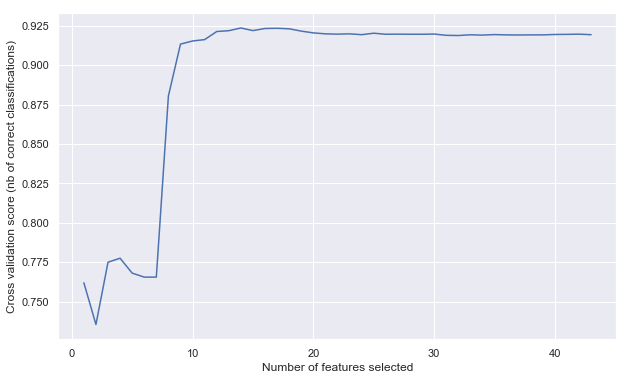

In [187]:
#Remove variables that consist of all NANs
drop_cols = [x for x in final_raw_df if final_raw_df[x].isnull().sum() == len(final_raw_df)]
prepared_final = final_raw_df.drop(drop_cols, axis = 1)

features_list = list(prepared_final)
features_list.remove(target)

X = prepared_final.loc[:, features_list]
y = prepared_final.loc[:, dependent_var]
    
#Reduce Features for Optimal Set
X, optimized_model = hf.feature_reduction(LogisticRegression(solver = 'lbfgs'), target_metric, X, y)

In [188]:
#Create New Training Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)
training_prepared_final =  X_train.join(y_train)

## Tune hyperparameters to find optimal Lasso Regression Coefficient

GridSearchCV is implemented in order to determinte the optimal 'C' (the inverse of λ) for the model using 10 Kfolds.

In [189]:
param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(optimized_model, return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X_train, y_train.values.ravel())
final_model = gs.best_estimator_ 

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

best params: LogisticRegression(C=0.20001000000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
best params: {'C': 0.20001000000000002}
best score: 0.9260771730977582


# Step 5 - Pipeline 1: Score Model and Obtain Metrics

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


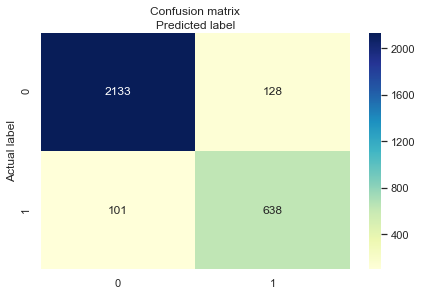

In [190]:
#Train and Score Final Model
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

hf.confusion_heat_map(y_test, y_pred)

In [191]:
print('Accuracy of final model on hold-out set: {:.3f}'.format(final_model.score(X_test, y_test)))
test_scores = cross_val_score(final_model, X_train, y_train.values.ravel(), cv=10)
print('Average accuracy for final model {:.3f}'.format(np.mean(test_scores)))
print()
print(classification_report(y_test, y_pred))

Accuracy of final model on hold-out set: 0.924


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Average accuracy for final model 0.926

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2261
           1       0.83      0.86      0.85       739

   micro avg       0.92      0.92      0.92      3000
   macro avg       0.89      0.90      0.90      3000
weighted avg       0.92      0.92      0.92      3000



/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


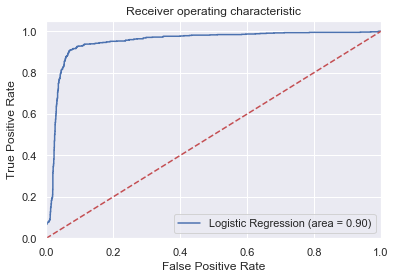

In [192]:
hf.ROC_curve(final_model, y_test, X_test)

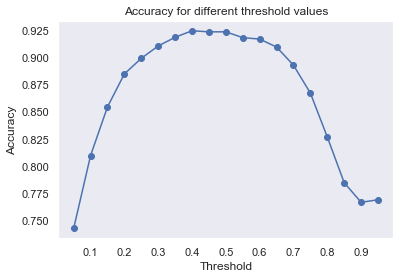

In [193]:
accuracy_list, threshold_list = hf.get_accuracy_list(final_model, X_test, y_test, y_pred)
hf.accuracy_plot(accuracy_list, threshold_list)

# Step 4 - Pipeline 2: Featuring Engineering with Polynomial Features

In [194]:
fe_functions = ['under_represented_features', 'projects_per_year', 'bin_continuous_var']
#, 'remove_outliers']

funcs, new_dataset = hf.feature_engineering_pipeline(encoded_df, target, size, seed, fe_functions)
accuracy = hf.cv_evaluate(new_dataset, 'left', splits=100)
print('Mean Accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Best Accuracy after CV: {:.3f}'.format(max(accuracy)))

Base Accuracy: 0.7777
- New Accuracy (under_represented_features): 0.7777 [diff: 0.0000] [Accepted]
- New Accuracy (projects_per_year): 0.8773 [diff: 0.0997] [Accepted]
- New Accuracy (bin_continuous_var): 0.9100 [diff: 0.0327] [Accepted]
Mean Accuracy after CV: 0.920 +/- 0.008
Best Accuracy after CV: 0.935


In [195]:
# Start with non-standardized data to prevent signal dampening
pol = PolynomialFeatures(3)
pol_features = pol.fit_transform(new_dataset[non_bool_numerics])
pol_features = pd.DataFrame(hf.standardize2(pol_features))

features = list(booleans)
features.remove(target)
X = pol_features.join(encoded_df[features])

X = hf.correlation_removal(X, 0.99)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Need to remove 4 columns with >= 0.99 correlation.


Optimal number of features: 32
Selected features: [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 18, 21, 22, 23, 25, 26, 28, 30, 34, 35, 37, 42, 43, 44, 46, 50, 51, 52, 54, 'Work_accident', 'promotion_last_5years', 'salary_high']


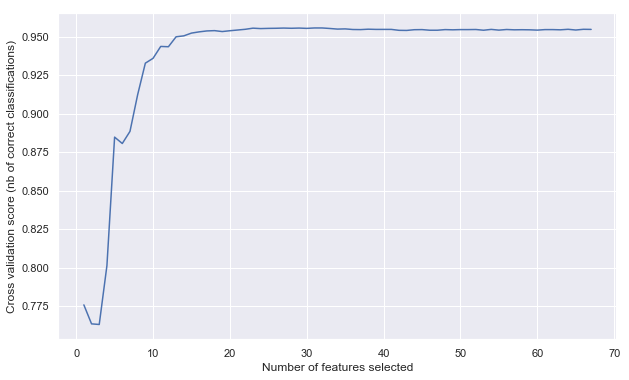

In [196]:
#Reduce Features for Optimal Set
X, optimized_model = hf.feature_reduction(LogisticRegression(solver='lbfgs'), target_metric, X, y)

In [197]:
#Create New Training Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)

Tune hyperparameters to find optimal Lasso Regression Coefficient

In [198]:
gs = GridSearchCV(optimized_model, return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X_train, y_train.values.ravel())
final_model = gs.best_estimator_ 

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

best params: LogisticRegression(C=2.50001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
best params: {'C': 2.50001}
best score: 0.9575797983165264


# Step 5 - Pipeline 2: Score Model and Obtain Metrics

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


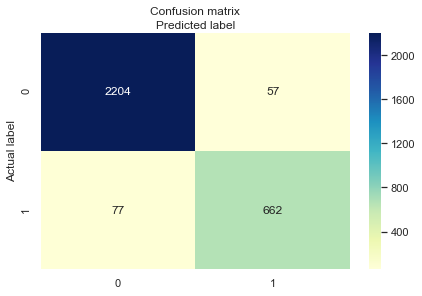

In [199]:
#Run model with final model
final_model.fit(X_train,y_train)
y_pred = final_model.predict(X_test)

hf.confusion_heat_map(y_test, y_pred)

In [200]:
print('Accuracy of final model on hold-out set: {:.3f}'.format(final_model.score(X_test, y_test)))
test_scores = cross_val_score(final_model, X_train, y_train.values.ravel(), cv=10)
print('Average accuracy for final model {:.3f}'.format(np.mean(test_scores)))
print()
print()
print(classification_report(y_test, y_pred))

Accuracy of final model on hold-out set: 0.955


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Average accuracy for final model 0.958


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2261
           1       0.92      0.90      0.91       739

   micro avg       0.96      0.96      0.96      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.96      0.96      0.96      3000



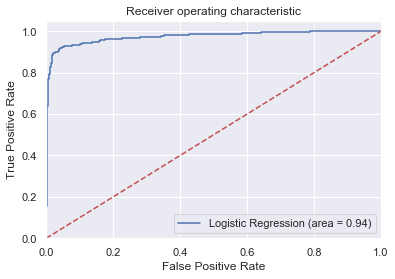

In [201]:
hf.ROC_curve(final_model, y_test, X_test)

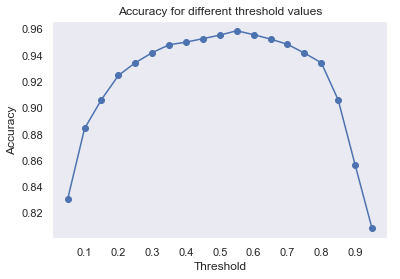

In [202]:
accuracy_list, threshold_list = hf.get_accuracy_list(final_model, X_test, y_test, y_pred)
hf.accuracy_plot(accuracy_list, threshold_list)

# Conclusion

The two pipelines have yielded models with approximately 92.4% and 97.1% accuracy with final variable set sizes of 17 and 31 respectively. 